pip install keras --user

pip install tensorflow --user

In [56]:
import pandas as pd
import re
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns
sns.set(context='notebook',
        style='whitegrid',
        palette='deep',
        font='sans-serif',
        font_scale=1,
        color_codes=True,
        rc=None)

In [3]:
import statsmodels.graphics.tsaplots as sgt

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

## Investigating Raw Dataset

In [6]:
df = pd.read_csv('train_webTraffic.csv', sep = ',', error_bad_lines = False, warn_bad_lines = True)

In [7]:
df = df.fillna(method='ffill', downcast='infer') # Replacing nan values with forward fill
print('Dataframe shape: {}'.format(df.shape))

Dataframe shape: (145063, 551)


In [8]:
df.head(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,32,63,15,26,14,20,22,19,18,20
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,...,17,42,28,15,9,30,52,45,26,20
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,...,3,1,1,7,4,4,6,3,4,17


In [9]:
df.tail(3)

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,3,10,0,2,2,0,7,45,1,...,0,0,1,1,13,12,13,3,5,10
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,3,10,0,2,2,0,7,45,1,...,0,0,1,1,13,12,13,3,5,10
145062,Francisco_el_matemático_(serie_de_televisión_d...,3,10,0,2,2,0,7,45,1,...,0,0,1,1,13,12,13,3,5,10


In [10]:
df.describe()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
count,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,...,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05,1.450630e+05
mean,1.461286e+03,1.295925e+03,1.222612e+03,1.259592e+03,1.321828e+03,1.402050e+03,1.331557e+03,1.279047e+03,1.291399e+03,1.281002e+03,...,1.378118e+03,1.368023e+03,1.379966e+03,1.523802e+03,1.653968e+03,1.658464e+03,1.618572e+03,1.661596e+03,1.446207e+03,1.458626e+03
std,8.873699e+04,9.018942e+04,8.510946e+04,8.856250e+04,8.990985e+04,9.758516e+04,9.197007e+04,8.319567e+04,8.689615e+04,8.755667e+04,...,8.463419e+04,7.640019e+04,8.386287e+04,8.641616e+04,9.663499e+04,9.117389e+04,9.067765e+04,8.897567e+04,8.055218e+04,8.768318e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.300000e+01,8.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,8.000000e+00,9.000000e+00,1.100000e+01,1.100000e+01,1.200000e+01,...,2.100000e+01,2.100000e+01,1.900000e+01,1.900000e+01,2.000000e+01,2.100000e+01,2.200000e+01,2.200000e+01,2.100000e+01,2.000000e+01
50%,1.030000e+02,8.400000e+01,7.600000e+01,8.000000e+01,9.100000e+01,8.700000e+01,8.700000e+01,9.900000e+01,9.000000e+01,1.020000e+02,...,1.420000e+02,1.380000e+02,1.270000e+02,1.380000e+02,1.510000e+02,1.550000e+02,1.550000e+02,1.530000e+02,1.480000e+02,1.300000e+02
75%,4.970000e+02,4.620000e+02,4.450000e+02,4.310000e+02,4.900000e+02,4.890000e+02,4.860000e+02,5.000000e+02,4.870000e+02,4.980000e+02,...,5.940000e+02,5.870000e+02,5.590000e+02,6.140000e+02,6.420000e+02,6.530000e+02,6.390000e+02,6.340000e+02,6.200000e+02,5.500000e+02
max,2.038124e+07,2.075219e+07,1.957397e+07,2.043964e+07,2.077211e+07,2.254467e+07,2.121089e+07,1.910791e+07,1.999385e+07,2.020182e+07,...,2.420108e+07,2.253925e+07,2.505662e+07,2.586575e+07,2.834288e+07,2.691699e+07,2.702505e+07,2.607382e+07,2.436397e+07,2.614954e+07


In [11]:
print('Data range: {0} - {1}'.format(df.columns[1], df.columns[-1]))

Data range: 2015-07-01 - 2016-12-31


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: int64(550), object(1)
memory usage: 609.8+ MB


In [13]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=916)
    page_labels = sample['Page'].tolist()
    data_start = df.columns[1]
    data_end = df.columns[-1]
    series_samples = sample.loc[:,data_start:data_end]
    
    plt.figure(figsize=(20,6))
    
    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1)
    
    plt.title('Randomly Selected Wikipedia Page Daily Views Over Time')
    plt.legend(page_labels)

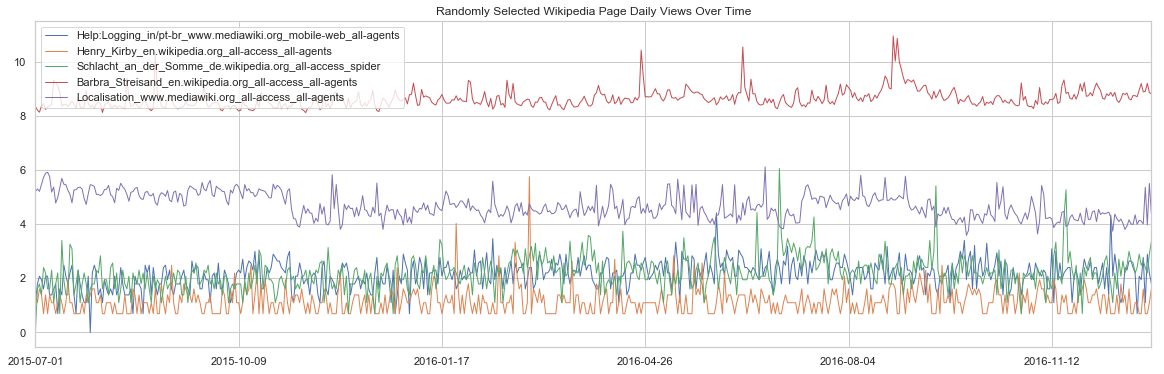

In [14]:
plot_random_series(df, 5)

In [15]:
train = pd.DataFrame(df.iloc[:,1:].values.T,
                     columns = df.Page.values, 
                     index=df.columns[1:])
train.index = pd.to_datetime(train.index, 
                             errors='ignore',
                             dayfirst=False,
                             yearfirst=False,
                             utc=None,
                             format="%Y/%m/%d",
                             exact=False,
                             unit=None,
                             infer_datetime_format=True,
                             origin='unix',
                             cache=True)

In [16]:
train.head(5)

,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,91Days_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,ASCII_zh.wikipedia.org_all-access_spider,...,Drake_(músico)_es.wikipedia.org_all-access_spider,Skam_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Legión_(serie_de_televisión)_es.wikipedia.org_all-access_spider,Doble_tentación_es.wikipedia.org_all-access_spider,Mi_adorable_maldición_es.wikipedia.org_all-access_spider,Underworld_(serie_de_películas)_es.wikipedia.org_all-access_spider,Resident_Evil:_Capítulo_Final_es.wikipedia.org_all-access_spider,Enamorándome_de_Ramón_es.wikipedia.org_all-access_spider,Hasta_el_último_hombre_es.wikipedia.org_all-access_spider,Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider
2015-07-01,18,11,1,35,35,12,12,118,5,6,...,3,3,3,3,3,3,3,3,3,3
2015-07-02,11,14,0,13,13,7,7,26,23,3,...,10,10,10,10,10,10,10,10,10,10
2015-07-03,5,15,1,10,10,4,4,30,14,5,...,0,0,0,0,0,0,0,0,0,0
2015-07-04,13,18,1,94,94,5,5,24,12,12,...,2,2,2,2,2,2,2,2,2,2
2015-07-05,14,11,0,4,4,20,20,29,9,6,...,2,2,2,2,2,2,2,2,2,2


In [17]:
wikipedia = (train.filter(like='wikipedia'))
print("Before filtering, shape = {0}".format(train.shape))
print("After filtering out non-wiki, shape = {0}".format(wikipedia.shape))

Before filtering, shape = (550, 145063)
After filtering out non-wiki, shape = (550, 127215)


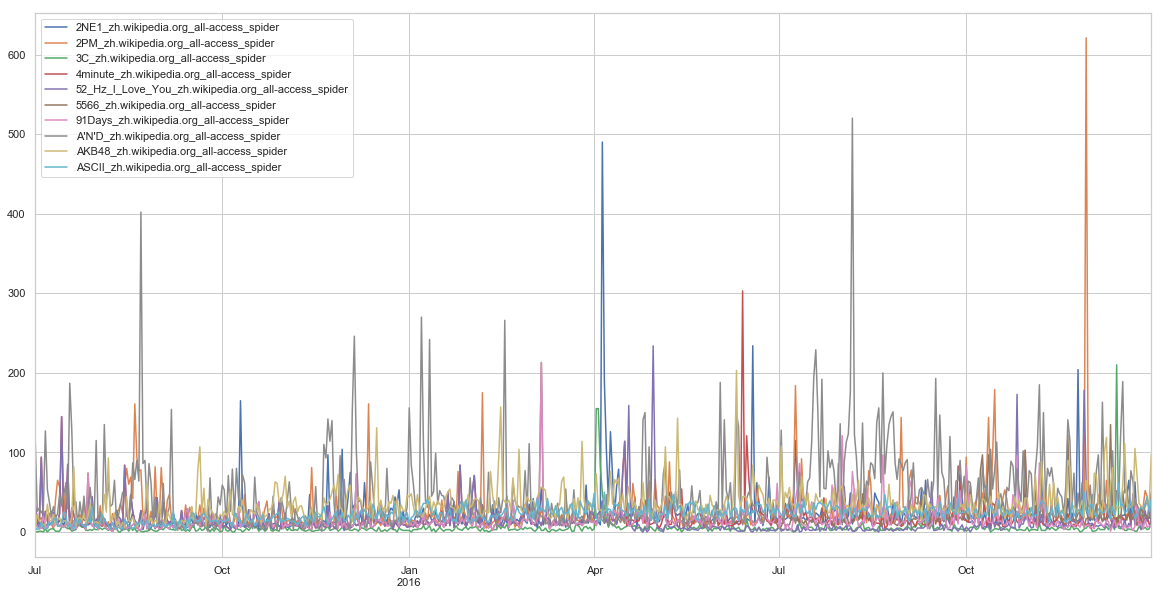

In [18]:
wikipedia.iloc[:,0:10].plot(figsize=(20,10))
plt.show()

## Time Series Analysis by Language

In [19]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org', page)
    if res:
        return res[0][0:2]
    return 'non-lang'

languages = list((wikipedia.columns.map(get_language)).unique())
languages.remove('non-lang')
print(languages)

['zh', 'fr', 'en', 'ru', 'de', 'ja', 'es']


In [20]:
lang_full = ['Chinese', 'French', 'English', 'Russian', 'German', 'Japanese', 'Spanish']
d = dict(zip(languages,lang_full))
d

{'zh': 'Chinese',
 'fr': 'French',
 'en': 'English',
 'ru': 'Russian',
 'de': 'German',
 'ja': 'Japanese',
 'es': 'Spanish'}

In [21]:
for lang in (languages):
    locals()['lang_'+str(lang)] = wikipedia.loc[:, wikipedia.columns.str.contains('_'+str(lang)+'.wiki')]

In [22]:
for lang in (languages):
    locals()['hits_'+str(lang)] = np.array(locals()['lang_'+str(lang)].iloc[:,:].sum(axis=1))

In [23]:
hits = pd.DataFrame(index = wikipedia.index, columns = list(d.values()))
hits = hits.fillna(0)
for key, value in d.items():
    hits[value] = locals()['hits_'+str(key)]

In [24]:
hits

,Chinese,French,English,Russian,German,Japanese,Spanish
2015-07-01,5456207,31228817,120391534,9801685,15081056,12029356,16103942
2015-07-02,4269619,8861578,119093656,9740966,14775940,13803809,15424574
2015-07-03,4427445,8511084,113155589,9005289,14216769,12371482,13831014
2015-07-04,4268193,9441573,117289794,8498550,12797849,15725650,12986072
2015-07-05,4559700,8958291,122355756,9658335,14941068,15235858,14225614
2015-07-06,4613626,9369348,131380055,9723883,16881788,13108292,16274769
2015-07-07,4635611,9100396,122962968,9497209,16300853,12683636,15827169
2015-07-08,5104281,9065408,115307608,9449764,16426990,12620835,15453897
2015-07-09,4850705,8886713,118890448,9707698,15807941,12282315,15003052
2015-07-10,5378798,8413555,117316213,11595516,14704404,12720635,13800459


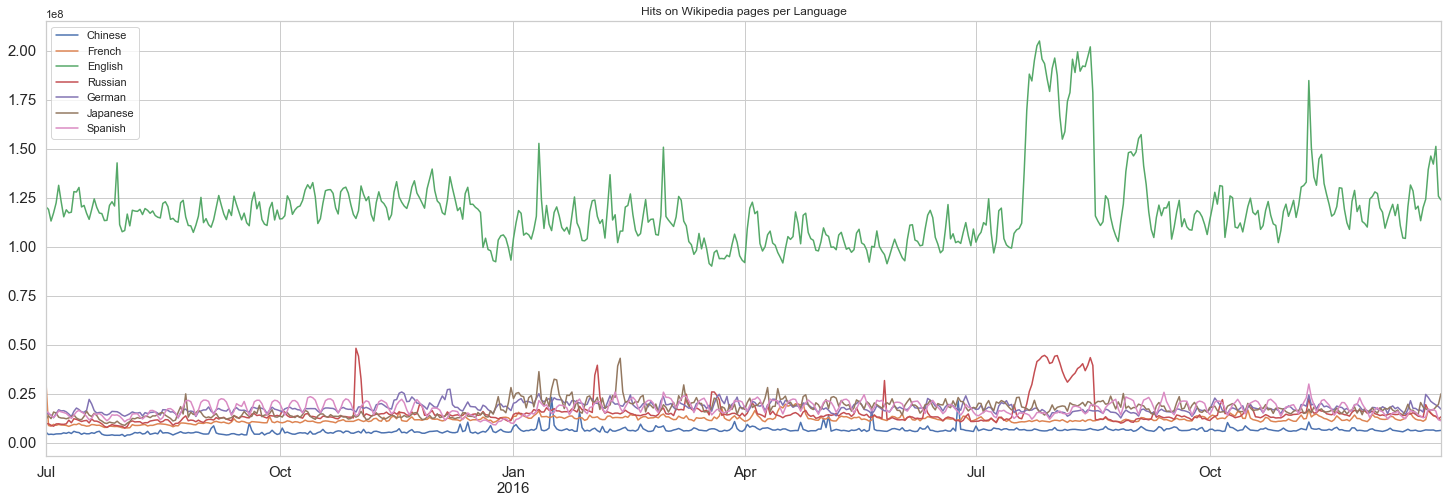

In [25]:
hits.plot(figsize=(25,8), title ='Hits on Wikipedia pages per Language', fontsize=15)
plt.legend(loc='upper left')
plt.show()

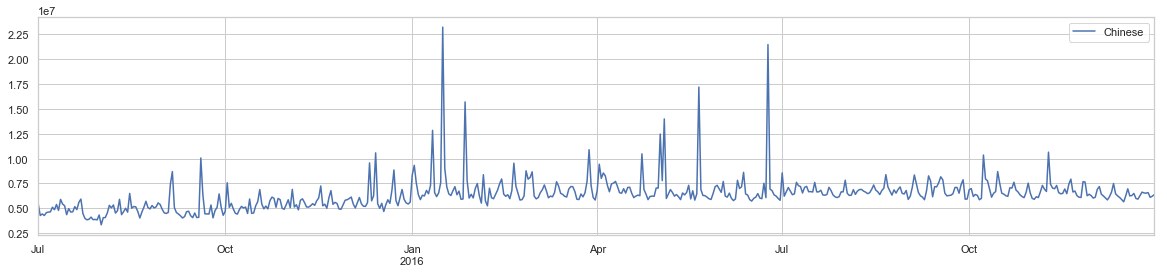

In [26]:
# plt.rcParams["figure.dpi"] = 100
hits.iloc[:,0:1].plot(figsize=(20,4))
plt.show()

/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead
  # This is added back by InteractiveShellApp.init_path()


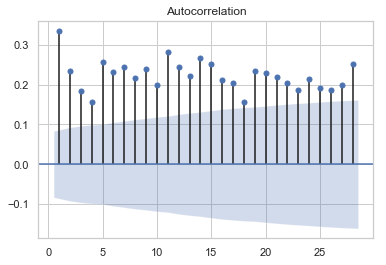

In [27]:
sgt.plot_acf(np.array(hits.iloc[:,0:1]),
            ax=None,
            lags=None,
            alpha=0.05,
            use_vlines=True,
            unbiased=False,
            fft=False,
            missing='none',
            title='Autocorrelation',
            zero=False,  # Not including the 1st term as its acf w.r.t. itself will always be 1.
            vlines_kwargs=None)
plt.show()

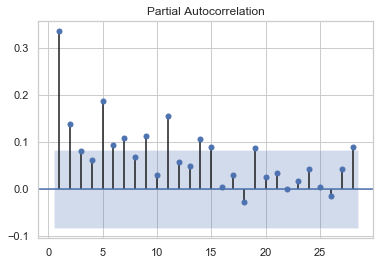

In [28]:
sgt.plot_pacf(np.array(hits.iloc[:,0:1]),
            ax=None,
            lags=None,
            alpha=0.05,
            method='ols',
            use_vlines=True,
            title='Partial Autocorrelation',
            zero=False,    # Not including the 1st term as its pacf w.r.t. itself will always be 1.
            vlines_kwargs=None)
plt.show()

## Prediction of #hits/language using LSTM

In [29]:
brk = 0.8
data_split = int(len(hits)*brk)
data_split

440

In [30]:
X, y = hits.iloc[:data_split,:], hits.iloc[data_split:,:]

In [31]:
scaler = MinMaxScaler()
scaler.fit(X)

print(X.shape)
print(y.shape)

scaled_X = scaler.transform(X)
scaled_y = scaler.transform(y)

(440, 7)
(110, 7)


/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [32]:
print(scaled_X.shape)
print(scaled_y.shape)

(440, 7)
(110, 7)


In [33]:
print(scaled_X.max(), scaled_X.min())
print(scaled_y.max(), scaled_y.min())

1.0 0.0
1.247600801777848 0.056305299568402356


In [34]:
X_df = (pd.DataFrame(scaled_X))
y_df = (pd.DataFrame(scaled_y))
X_df.set_axis(lang_full, axis=1)
y_df.set_axis(lang_full, axis=1)
X_df

/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chih-hsuankao/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  after removing the cwd from sys.path.


,Chinese,French,English,Russian,German,Japanese,Spanish
0,0.106714,1.000000,0.263360,0.055114,0.162612,0.090555,0.414688
1,0.047059,0.052525,0.252059,0.053622,0.141856,0.142399,0.374003
2,0.054994,0.037678,0.200352,0.035544,0.103819,0.100551,0.278571
3,0.046987,0.077094,0.236351,0.023092,0.007297,0.198549,0.227971
4,0.061643,0.056622,0.280464,0.051592,0.153089,0.184239,0.302202
5,0.064354,0.074034,0.359044,0.053202,0.285107,0.122078,0.424918
6,0.065459,0.062641,0.285751,0.047632,0.245588,0.109671,0.398113
7,0.089021,0.061159,0.219091,0.046466,0.254169,0.107836,0.375759
8,0.076273,0.053590,0.250289,0.052805,0.212058,0.097946,0.348760
9,0.102823,0.033547,0.236581,0.099195,0.136990,0.110752,0.276742


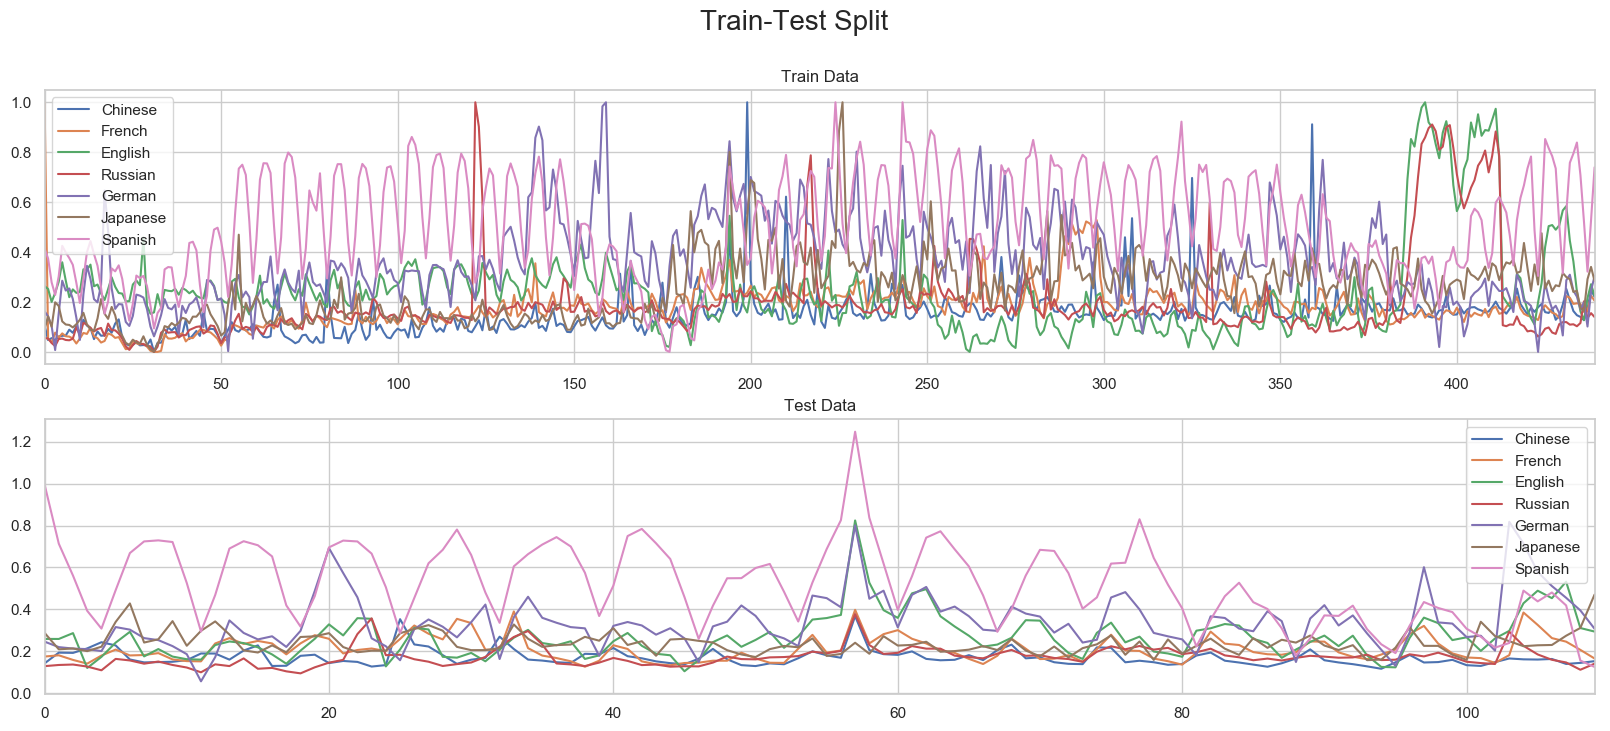

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8), dpi=100)
plt.suptitle('Train-Test Split', fontsize=20)
X_df.plot(ax=axes[0], title='Train Data')
y_df.plot(ax=axes[1], title='Test Data')

plt.show()

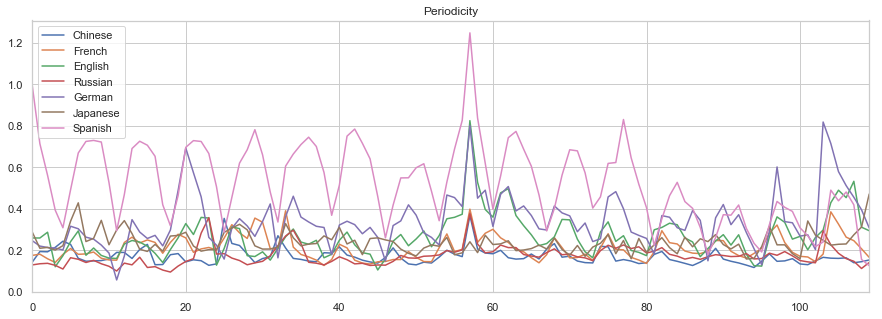

In [36]:
pd.DataFrame(scaled_y[:,:]).plot(figsize=(15,5), title='Periodicity')
plt.legend(lang_full)
plt.show()

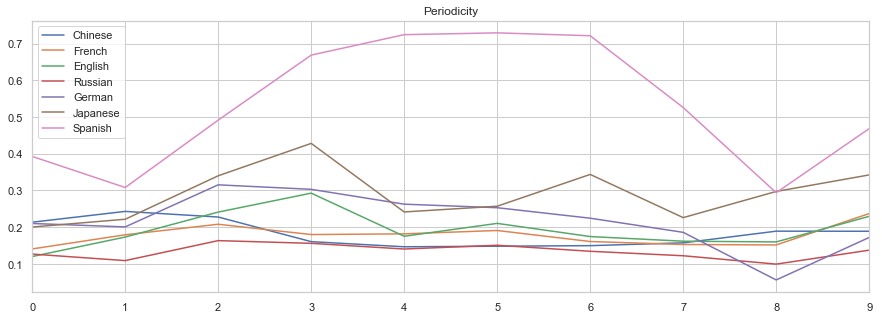

In [37]:
pd.DataFrame(scaled_y[3:13,:]).plot(figsize=(15,5), title='Periodicity')
plt.legend(lang_full)
plt.show()

In [38]:
print(scaled_X.shape)
print(scaled_y.shape)
print('No. of features = ' + str(scaled_X.shape[1]))
print('No. of train instances = ' + str(scaled_X.shape[0]))
print('No. of test instances = ' + str(scaled_y.shape[0]))

(440, 7)
(110, 7)
No. of features = 7
No. of train instances = 440
No. of test instances = 110


In [39]:
length = 7
batch = 1
n_features = scaled_X.shape[1]

generator = TimeseriesGenerator(data = scaled_X,
                                targets = scaled_X,
                                length = length,
                                sampling_rate=1,
                                stride=1,
                                start_index=0,
                                end_index=None,
                                shuffle=False,
                                reverse=False,
                                batch_size=batch)

In [40]:
model = Sequential(layers=None, name="LSTM_Model")

model.add(LSTM( units = 400,               
                activation='tanh',
                input_shape=( length, n_features),                
                recurrent_activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                recurrent_initializer='orthogonal',
                bias_initializer='zeros',
                unit_forget_bias=True,
                kernel_regularizer=None,
                recurrent_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                recurrent_constraint=None,
                bias_constraint=None,
                dropout=0.0,
                recurrent_dropout=0.0,
                implementation=2,
                return_sequences=True,
                return_state=False,
                go_backwards=False,
                stateful=False,
                time_major=False,
                unroll=False
            ) )
model.add(LSTM(units = 500, return_sequences=True))
model.add(LSTM(units = 500, return_sequences=False))
model.add(Dense(700, activation="relu", name="layer1"))
model.add(Dense(100, activation="relu", name="layer2"))
model.add(Dense(units = n_features,               
                activation='relu',
                use_bias=True,                        
                kernel_initializer='glorot_uniform',  
                bias_initializer='zeros',             
                kernel_regularizer=None,              
                bias_regularizer=None,                
                activity_regularizer=None,            
                kernel_constraint=None,               
                bias_constraint=None))                


In [41]:
model.compile(optimizer='adam', loss='mse')

In [42]:
model.summary()

Model: "LSTM_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 400)            652800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 500)            1802000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
layer1 (Dense)               (None, 700)               350700    
_________________________________________________________________
layer2 (Dense)               (None, 100)               70100     
_________________________________________________________________
dense (Dense)                (None, 7)                 707       
Total params: 4,878,307
Trainable params: 4,878,307
Non-trainable params: 0
______________________________________________

In [43]:
early_stop = EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=20,
                        verbose=1,  
                        mode='auto',
                        baseline=None,                        
                        restore_best_weights=False)

In [44]:
validation_generator = TimeseriesGenerator(scaled_y, scaled_y, length=length, batch_size=batch)

In [45]:
history = model.fit(generator,
                    steps_per_epoch=None,
                    epochs=500,
                    verbose=1,
                    callbacks=[early_stop],
                    validation_data = validation_generator,
                    validation_steps=None,
                    validation_freq=1,
                    class_weight=None,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0)

Epoch 1/500
433/433 [==============================] - 18s 34ms/step - loss: 0.0266 - val_loss: 0.0103
Epoch 2/500
433/433 [==============================] - 13s 30ms/step - loss: 0.0188 - val_loss: 0.0083
Epoch 3/500
433/433 [==============================] - 14s 32ms/step - loss: 0.0159 - val_loss: 0.0089
Epoch 4/500
433/433 [==============================] - 17s 39ms/step - loss: 0.0148 - val_loss: 0.0076
Epoch 5/500
433/433 [==============================] - 15s 35ms/step - loss: 0.0114 - val_loss: 0.0096
Epoch 6/500
433/433 [==============================] - 15s 34ms/step - loss: 0.0133 - val_loss: 0.0079
Epoch 7/500
433/433 [==============================] - 15s 35ms/step - loss: 0.0135 - val_loss: 0.0076
Epoch 8/500
433/433 [==============================] - 15s 35ms/step - loss: 0.0101 - val_loss: 0.0070
Epoch 9/500
433/433 [==============================] - 15s 34ms/step - loss: 0.0084 - val_loss: 0.0076
Epoch 10/500
433/433 [==============================] - 15s 35ms/step - l

In [46]:
print(history.history.keys())
losses = pd.DataFrame(model.history.history)

dict_keys(['loss', 'val_loss'])


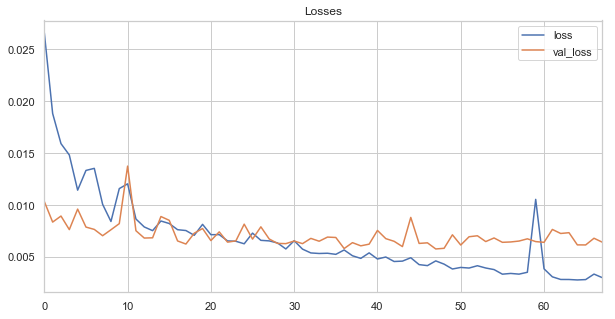

In [47]:
losses.plot(figsize=(10,5))
plt.title('Losses')
plt.show()

In [48]:
test_predictions = []

first_eval_batch = scaled_X[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_y)):
    current_pred = model.predict(current_batch,verbose=0)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [49]:
print(np.array(test_predictions).shape)
print(scaled_y.shape)
true_predictions = scaler.inverse_transform(test_predictions)
print(true_predictions.shape)

(110, 7)
(110, 7)
(110, 7)


In [50]:
scaled_y[:,0:1].shape

(110, 1)

In [51]:
np.linspace(start=0,stop=110,num=110)

array([  0.        ,   1.00917431,   2.01834862,   3.02752294,
         4.03669725,   5.04587156,   6.05504587,   7.06422018,
         8.0733945 ,   9.08256881,  10.09174312,  11.10091743,
        12.11009174,  13.11926606,  14.12844037,  15.13761468,
        16.14678899,  17.1559633 ,  18.16513761,  19.17431193,
        20.18348624,  21.19266055,  22.20183486,  23.21100917,
        24.22018349,  25.2293578 ,  26.23853211,  27.24770642,
        28.25688073,  29.26605505,  30.27522936,  31.28440367,
        32.29357798,  33.30275229,  34.31192661,  35.32110092,
        36.33027523,  37.33944954,  38.34862385,  39.35779817,
        40.36697248,  41.37614679,  42.3853211 ,  43.39449541,
        44.40366972,  45.41284404,  46.42201835,  47.43119266,
        48.44036697,  49.44954128,  50.4587156 ,  51.46788991,
        52.47706422,  53.48623853,  54.49541284,  55.50458716,
        56.51376147,  57.52293578,  58.53211009,  59.5412844 ,
        60.55045872,  61.55963303,  62.56880734,  63.57

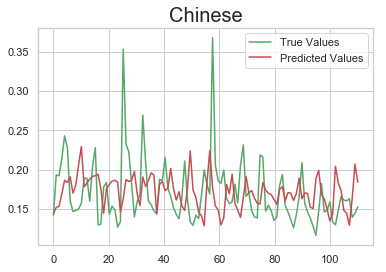

In [54]:
plt.plot(np.linspace(start=0,stop=len(scaled_y),num=len(scaled_y)),
         scaled_y[:,0:1] , 
         label='True Values', 
         color='g')
plt.plot(np.linspace(0,len(scaled_y),len(scaled_y)),
         np.array(test_predictions)[:,0:1],
         label='Predicted Values',c='r')
plt.title(hits.columns[0], fontsize=20)
plt.legend()
plt.show()

In [58]:
rmse_list = []
for i in range(7):
    rmse = math.sqrt(mean_squared_error(scaled_y[:,i:(i+1)], np.array(test_predictions)[:,i:(i+1)]))
    rmse_list.append(rmse)

dict_RMSE = {'Language': lang_full,
             'Root Mean Squared Error (RMSE)': rmse_list}  

df_langRMSE = pd.DataFrame(dict_RMSE) 
df_langRMSE.sort_values(by=['Root Mean Squared Error (RMSE)'])

,Language,Root Mean Squared Error (RMSE)
0,Chinese,0.044764
1,French,0.075858
3,Russian,0.094387
5,Japanese,0.128467
2,English,0.170456
4,German,0.181425
6,Spanish,0.229789
